In [1]:
from experiment import Experiment
import torch
torch.manual_seed(2)
%matplotlib inline

In [2]:
var_dict = dict(
    categorical_vars = ['Work_accident', 'promotion_last_5years', 'sales', 
                        'salary'],
    numerical_vars = ['satisfaction_level', 'last_evaluation', 'average_montly_hours'
                     ,'number_project','time_spend_company'],
    class_var = 'left'
)

In [3]:
exp = Experiment('data/HR_comma_sep.csv', 
                 var_dict,
                 embedding_dim=8,
                 lr=0.001,
                 batch_size=1024,
                 inter_bin_distance_penalty=0.0,
                 n_epoch=100,
                 verbose=True,
                 n_bins_range=range(2,21),
                 n_init_bins_list=[5,10,15,20,30])

In [105]:
%time clf_scores = exp.test_classification_performance(cv=5)

>>> Epoch = 1, Loss = 0.6593228578567505
[4, 2, 5]
>>> Epoch = 2, Loss = 0.5700353384017944
[4, 2, 5]
>>> Epoch = 3, Loss = 0.48434922099113464
[4, 2, 4]
>>> Epoch = 4, Loss = 0.43091392517089844
[4, 2, 4]
>>> Epoch = 5, Loss = 0.4055575430393219
[4, 2, 4]
>>> Epoch = 6, Loss = 0.3895999789237976
[4, 2, 4]
>>> Epoch = 7, Loss = 0.3833932876586914
[4, 2, 4]
>>> Epoch = 8, Loss = 0.37656310200691223
[4, 2, 4]
>>> Epoch = 9, Loss = 0.3733745217323303
[4, 2, 4]
>>> Epoch = 10, Loss = 0.3736618161201477
[4, 2, 4]
>>> Epoch = 11, Loss = 0.3685719966888428
[4, 2, 4]
>>> Epoch = 12, Loss = 0.36975669860839844
[4, 2, 2]
>>> Epoch = 13, Loss = 0.3655836582183838
[4, 2, 2]
>>> Epoch = 14, Loss = 0.3701380491256714
[4, 2, 2]
>>> Epoch = 15, Loss = 0.3659350275993347
[4, 2, 2]
>>> Epoch = 16, Loss = 0.3668992817401886
[4, 2, 2]
>>> Epoch = 17, Loss = 0.36475974321365356
[4, 2, 2]
>>> Epoch = 18, Loss = 0.3675316572189331
[4, 2, 2]
>>> Epoch = 19, Loss = 0.3634430766105652
[4, 2, 2]
>>> Epoch = 20, 

[3, 3, 4]
>>> Epoch = 58, Loss = 0.29780787229537964
[3, 3, 4]
>>> Epoch = 59, Loss = 0.2998062074184418
[3, 3, 4]
>>> Epoch = 60, Loss = 0.2999211549758911
[3, 3, 4]
>>> Epoch = 61, Loss = 0.2977924346923828
[3, 3, 4]
>>> Epoch = 62, Loss = 0.29867425560951233
[3, 3, 4]
>>> Epoch = 63, Loss = 0.29600271582603455
[3, 3, 4]
>>> Epoch = 64, Loss = 0.3002479672431946
[3, 3, 4]
>>> Epoch = 65, Loss = 0.2987036406993866
[3, 3, 4]
>>> Epoch = 66, Loss = 0.29834964871406555
[3, 3, 4]
>>> Epoch = 67, Loss = 0.29818251729011536
[3, 3, 4]
>>> Epoch = 68, Loss = 0.2973659336566925
[3, 3, 4]
>>> Epoch = 69, Loss = 0.29995453357696533
[3, 3, 4]
>>> Epoch = 70, Loss = 0.29924750328063965
[3, 3, 4]
>>> Epoch = 71, Loss = 0.29797860980033875
[3, 3, 4]
>>> Epoch = 72, Loss = 0.2976129651069641
[3, 2, 4]
>>> Epoch = 73, Loss = 0.2992244064807892
[3, 3, 3]
>>> Epoch = 74, Loss = 0.29563748836517334
[3, 3, 3]
>>> Epoch = 75, Loss = 0.2961478531360626
[3, 3, 3]
>>> Epoch = 76, Loss = 0.2974027395248413
[3,

[19, 19, 19]
>>> Epoch = 12, Loss = 0.23084507882595062
[20, 19, 19]
>>> Epoch = 13, Loss = 0.2315736711025238
[19, 19, 18]
>>> Epoch = 14, Loss = 0.2301945984363556
[19, 19, 19]
>>> Epoch = 15, Loss = 0.2296571582555771
[17, 19, 19]
>>> Epoch = 16, Loss = 0.22917915880680084
[19, 19, 18]
>>> Epoch = 17, Loss = 0.22799603641033173
[19, 19, 19]
>>> Epoch = 18, Loss = 0.22656339406967163
[20, 19, 17]
>>> Epoch = 19, Loss = 0.22788120806217194
[19, 19, 18]
>>> Epoch = 20, Loss = 0.2262643426656723
[18, 19, 19]
>>> Epoch = 21, Loss = 0.22658522427082062
[18, 19, 19]
>>> Epoch = 22, Loss = 0.2270509898662567
[19, 19, 18]
>>> Epoch = 23, Loss = 0.22697927057743073
[19, 19, 16]
>>> Epoch = 24, Loss = 0.2290518432855606
[19, 12, 18]
>>> Epoch = 25, Loss = 0.22736293077468872
[19, 10, 18]
>>> Epoch = 26, Loss = 0.2273169755935669
[19, 18, 14]
>>> Epoch = 27, Loss = 0.22640495002269745
[18, 18, 19]
>>> Epoch = 28, Loss = 0.2255404144525528
[18, 18, 16]
>>> Epoch = 29, Loss = 0.22520416975021362


[7, 6, 7]
>>> Epoch = 63, Loss = 0.17633499205112457
[7, 6, 7]
>>> Epoch = 64, Loss = 0.17537039518356323
[7, 6, 7]
>>> Epoch = 65, Loss = 0.1750727891921997
[7, 6, 7]
>>> Epoch = 66, Loss = 0.17528079450130463
[7, 6, 5]
>>> Epoch = 67, Loss = 0.1763158142566681
[5, 4, 5]
>>> Epoch = 68, Loss = 0.17642860114574432
[3, 4, 5]
>>> Epoch = 69, Loss = 0.17516197264194489
[3, 4, 5]
>>> Epoch = 70, Loss = 0.17578108608722687
[3, 4, 5]
>>> Epoch = 71, Loss = 0.17444822192192078
[3, 4, 5]
>>> Epoch = 72, Loss = 0.17552070319652557
[3, 4, 5]
>>> Epoch = 73, Loss = 0.17458617687225342
[3, 4, 5]
>>> Epoch = 74, Loss = 0.17462073266506195
[3, 2, 5]
>>> Epoch = 75, Loss = 0.17603632807731628
[3, 2, 5]
>>> Epoch = 76, Loss = 0.17491579055786133
[3, 2, 5]
>>> Epoch = 77, Loss = 0.17591066658496857
[3, 2, 5]
>>> Epoch = 78, Loss = 0.1731526106595993
[3, 2, 5]
>>> Epoch = 79, Loss = 0.17466534674167633
[4, 2, 8]
>>> Epoch = 80, Loss = 0.17378294467926025
[4, 2, 5]
>>> Epoch = 81, Loss = 0.17352563142776

[8, 8, 8]
>>> Epoch = 19, Loss = 0.3074006736278534
[8, 8, 8]
>>> Epoch = 20, Loss = 0.30644112825393677
[8, 8, 8]
>>> Epoch = 21, Loss = 0.3059585392475128
[8, 8, 8]
>>> Epoch = 22, Loss = 0.30725160241127014
[8, 8, 8]
>>> Epoch = 23, Loss = 0.30662763118743896
[8, 8, 8]
>>> Epoch = 24, Loss = 0.30578693747520447
[8, 8, 8]
>>> Epoch = 25, Loss = 0.30619150400161743
[8, 8, 8]
>>> Epoch = 26, Loss = 0.3063895106315613
[8, 8, 8]
>>> Epoch = 27, Loss = 0.30425551533699036
[8, 8, 8]
>>> Epoch = 28, Loss = 0.3035184144973755
[8, 8, 7]
>>> Epoch = 29, Loss = 0.3062918186187744
[8, 8, 7]
>>> Epoch = 30, Loss = 0.305905282497406
[8, 8, 7]
>>> Epoch = 31, Loss = 0.3055964708328247
[8, 8, 7]
>>> Epoch = 32, Loss = 0.3046349287033081
[8, 8, 7]
>>> Epoch = 33, Loss = 0.3042390048503876
[8, 8, 7]
>>> Epoch = 34, Loss = 0.3049599826335907
[8, 8, 7]
>>> Epoch = 35, Loss = 0.3059702217578888
[8, 8, 4]
>>> Epoch = 36, Loss = 0.3036317229270935
[8, 8, 7]
>>> Epoch = 37, Loss = 0.3048344850540161
[6, 8, 

[7, 4, 10]
>>> Epoch = 75, Loss = 0.25321492552757263
[7, 4, 10]
>>> Epoch = 76, Loss = 0.2532517910003662
[7, 4, 10]
>>> Epoch = 77, Loss = 0.2521454989910126
[7, 4, 10]
>>> Epoch = 78, Loss = 0.25288161635398865
[2, 3, 10]
>>> Epoch = 79, Loss = 0.2543014585971832
[2, 2, 10]
>>> Epoch = 80, Loss = 0.2509508430957794
[2, 2, 10]
>>> Epoch = 81, Loss = 0.2541976869106293
[2, 2, 2]
>>> Epoch = 82, Loss = 0.25126564502716064
[2, 2, 2]
>>> Epoch = 83, Loss = 0.25115469098091125
[2, 2, 2]
>>> Epoch = 84, Loss = 0.2528235912322998
[2, 2, 2]
>>> Epoch = 85, Loss = 0.25389888882637024
[2, 2, 2]
>>> Epoch = 86, Loss = 0.2520659863948822
[2, 2, 2]
>>> Epoch = 87, Loss = 0.2489294707775116
[2, 2, 2]
>>> Epoch = 88, Loss = 0.251570463180542
[2, 2, 2]
>>> Epoch = 89, Loss = 0.2521573007106781
[2, 2, 8]
>>> Epoch = 90, Loss = 0.25135958194732666
[4, 2, 2]
>>> Epoch = 91, Loss = 0.25134965777397156
[4, 2, 2]
>>> Epoch = 92, Loss = 0.2525410056114197
[4, 2, 2]
>>> Epoch = 93, Loss = 0.2504937648773193

[17, 17, 28]
>>> Epoch = 26, Loss = 0.17944610118865967
[17, 17, 28]
>>> Epoch = 27, Loss = 0.17957057058811188
[24, 17, 29]
>>> Epoch = 28, Loss = 0.17944715917110443
[23, 17, 28]
>>> Epoch = 29, Loss = 0.18109923601150513
[23, 17, 27]
>>> Epoch = 30, Loss = 0.18033121526241302
[24, 17, 28]
>>> Epoch = 31, Loss = 0.18008512258529663
[20, 17, 29]
>>> Epoch = 32, Loss = 0.17937642335891724
[20, 17, 28]
>>> Epoch = 33, Loss = 0.18070274591445923
[20, 17, 28]
>>> Epoch = 34, Loss = 0.1802929937839508
[24, 17, 28]
>>> Epoch = 35, Loss = 0.1781749576330185
[22, 17, 28]
>>> Epoch = 36, Loss = 0.17823195457458496
[24, 17, 28]
>>> Epoch = 37, Loss = 0.17732493579387665
[24, 17, 28]
>>> Epoch = 38, Loss = 0.17886419594287872
[24, 17, 28]
>>> Epoch = 39, Loss = 0.17768947780132294
[24, 13, 28]
>>> Epoch = 40, Loss = 0.17913392186164856
[17, 13, 28]
>>> Epoch = 41, Loss = 0.17912745475769043
[12, 13, 14]
>>> Epoch = 42, Loss = 0.1794663965702057
[22, 13, 14]
>>> Epoch = 43, Loss = 0.1784465461969

>>> Epoch = 80, Loss = 0.35219714045524597
[2, 3, 2]
>>> Epoch = 81, Loss = 0.3522758185863495
[2, 3, 2]
>>> Epoch = 82, Loss = 0.3502177894115448
[3, 3, 2]
>>> Epoch = 83, Loss = 0.3513997197151184
[3, 3, 2]
>>> Epoch = 84, Loss = 0.35089176893234253
[3, 3, 2]
>>> Epoch = 85, Loss = 0.3496381640434265
[3, 3, 2]
>>> Epoch = 86, Loss = 0.35153812170028687
[3, 3, 2]
>>> Epoch = 87, Loss = 0.34991171956062317
[3, 3, 2]
>>> Epoch = 88, Loss = 0.3515782654285431
[3, 3, 2]
>>> Epoch = 89, Loss = 0.35162946581840515
[3, 3, 2]
>>> Epoch = 90, Loss = 0.3517896831035614
[3, 3, 2]
>>> Epoch = 91, Loss = 0.3486644923686981
[3, 3, 2]
>>> Epoch = 92, Loss = 0.35091710090637207
[3, 3, 2]
>>> Epoch = 93, Loss = 0.35378575325012207
[3, 3, 2]
>>> Epoch = 94, Loss = 0.3509743809700012
[3, 3, 2]
>>> Epoch = 95, Loss = 0.35003334283828735
[3, 3, 2]
>>> Epoch = 96, Loss = 0.3501078188419342
[3, 3, 2]
>>> Epoch = 97, Loss = 0.34949663281440735
[3, 3, 2]
>>> Epoch = 98, Loss = 0.3495083153247833
[3, 3, 2]
>>>

>>> Epoch = 34, Loss = 0.2582825720310211
[8, 5, 12]
>>> Epoch = 35, Loss = 0.25855427980422974
[8, 5, 9]
>>> Epoch = 36, Loss = 0.2580623924732208
[8, 9, 12]
>>> Epoch = 37, Loss = 0.25905632972717285
[6, 7, 12]
>>> Epoch = 38, Loss = 0.2566809058189392
[8, 7, 9]
>>> Epoch = 39, Loss = 0.2595316469669342
[6, 7, 9]
>>> Epoch = 40, Loss = 0.25778040289878845
[6, 3, 9]
>>> Epoch = 41, Loss = 0.25755760073661804
[6, 3, 9]
>>> Epoch = 42, Loss = 0.2585325539112091
[6, 7, 9]
>>> Epoch = 43, Loss = 0.25570982694625854
[6, 7, 9]
>>> Epoch = 44, Loss = 0.25777673721313477
[6, 6, 5]
>>> Epoch = 45, Loss = 0.2567559778690338
[6, 8, 6]
>>> Epoch = 46, Loss = 0.2557016611099243
[6, 6, 6]
>>> Epoch = 47, Loss = 0.25732195377349854
[6, 7, 6]
>>> Epoch = 48, Loss = 0.2567787170410156
[6, 2, 6]
>>> Epoch = 49, Loss = 0.2567949593067169
[6, 2, 6]
>>> Epoch = 50, Loss = 0.25505000352859497
[6, 2, 6]
>>> Epoch = 51, Loss = 0.255079984664917
[6, 2, 6]
>>> Epoch = 52, Loss = 0.2558242082595825
[6, 2, 6]
>>

>>> Epoch = 87, Loss = 0.21974381804466248
[4, 3, 3]
>>> Epoch = 88, Loss = 0.21884191036224365
[4, 3, 3]
>>> Epoch = 89, Loss = 0.22075383365154266
[4, 3, 3]
>>> Epoch = 90, Loss = 0.22055737674236298
[4, 3, 3]
>>> Epoch = 91, Loss = 0.22058847546577454
[4, 3, 4]
>>> Epoch = 92, Loss = 0.2198181301355362
[4, 3, 4]
>>> Epoch = 93, Loss = 0.22003285586833954
[4, 3, 4]
>>> Epoch = 94, Loss = 0.21722720563411713
[4, 3, 4]
>>> Epoch = 95, Loss = 0.2183816283941269
[4, 3, 4]
>>> Epoch = 96, Loss = 0.21775029599666595
[4, 3, 4]
>>> Epoch = 97, Loss = 0.21979115903377533
[4, 3, 4]
>>> Epoch = 98, Loss = 0.21876494586467743
[4, 3, 4]
>>> Epoch = 99, Loss = 0.21923276782035828
[4, 3, 4]
>>> Epoch = 100, Loss = 0.2188410460948944
[4, 3, 4]
Learning Embedding Finished!
>>> Epoch = 1, Loss = 0.6487013101577759
[28, 18, 15]
>>> Epoch = 2, Loss = 0.5354557633399963
[27, 18, 28]
>>> Epoch = 3, Loss = 0.4018157422542572
[28, 18, 13]
>>> Epoch = 4, Loss = 0.29577943682670593
[28, 18, 13]
>>> Epoch = 5,

>>> Epoch = 39, Loss = 0.3590812683105469
[5, 4, 2]
>>> Epoch = 40, Loss = 0.35666361451148987
[5, 4, 2]
>>> Epoch = 41, Loss = 0.3580401539802551
[2, 4, 2]
>>> Epoch = 42, Loss = 0.35828155279159546
[2, 4, 2]
>>> Epoch = 43, Loss = 0.35698607563972473
[2, 4, 2]
>>> Epoch = 44, Loss = 0.35856691002845764
[2, 4, 2]
>>> Epoch = 45, Loss = 0.3553536832332611
[2, 4, 2]
>>> Epoch = 46, Loss = 0.35536086559295654
[2, 4, 2]
>>> Epoch = 47, Loss = 0.3559585213661194
[2, 4, 2]
>>> Epoch = 48, Loss = 0.35229256749153137
[2, 3, 2]
>>> Epoch = 49, Loss = 0.3538496196269989
[2, 3, 2]
>>> Epoch = 50, Loss = 0.3543047606945038
[2, 3, 2]
>>> Epoch = 51, Loss = 0.3541455566883087
[2, 3, 2]
>>> Epoch = 52, Loss = 0.35545113682746887
[2, 3, 2]
>>> Epoch = 53, Loss = 0.3545803427696228
[2, 3, 2]
>>> Epoch = 54, Loss = 0.3548241853713989
[2, 3, 2]
>>> Epoch = 55, Loss = 0.3537352681159973
[2, 2, 2]
>>> Epoch = 56, Loss = 0.35682061314582825
[2, 2, 2]
>>> Epoch = 57, Loss = 0.35324445366859436
[2, 2, 2]
>>>

[3, 2, 2]
>>> Epoch = 95, Loss = 0.29602062702178955
[3, 2, 4]
>>> Epoch = 96, Loss = 0.2958979904651642
[3, 2, 4]
>>> Epoch = 97, Loss = 0.2979940176010132
[3, 2, 4]
>>> Epoch = 98, Loss = 0.2972524166107178
[3, 2, 2]
>>> Epoch = 99, Loss = 0.29631736874580383
[3, 2, 4]
>>> Epoch = 100, Loss = 0.29586300253868103
[3, 2, 4]
Learning Embedding Finished!
>>> Epoch = 1, Loss = 0.6356567740440369
[10, 11, 15]
>>> Epoch = 2, Loss = 0.5235450863838196
[12, 11, 15]
>>> Epoch = 3, Loss = 0.4225786626338959
[11, 14, 15]
>>> Epoch = 4, Loss = 0.353748083114624
[5, 14, 9]
>>> Epoch = 5, Loss = 0.3214447796344757
[10, 14, 7]
>>> Epoch = 6, Loss = 0.3017307221889496
[4, 12, 11]
>>> Epoch = 7, Loss = 0.28789564967155457
[3, 12, 13]
>>> Epoch = 8, Loss = 0.28032153844833374
[6, 12, 13]
>>> Epoch = 9, Loss = 0.2767680287361145
[10, 12, 11]
>>> Epoch = 10, Loss = 0.2709847390651703
[9, 12, 11]
>>> Epoch = 11, Loss = 0.2689555883407593
[6, 12, 11]
>>> Epoch = 12, Loss = 0.26786503195762634
[6, 12, 11]
>

[16, 14, 12]
>>> Epoch = 47, Loss = 0.22156833112239838
[10, 14, 12]
>>> Epoch = 48, Loss = 0.2237943559885025
[16, 11, 12]
>>> Epoch = 49, Loss = 0.22145798802375793
[16, 11, 14]
>>> Epoch = 50, Loss = 0.22251902520656586
[16, 10, 12]
>>> Epoch = 51, Loss = 0.2229299396276474
[16, 11, 12]
>>> Epoch = 52, Loss = 0.22088401019573212
[16, 12, 15]
>>> Epoch = 53, Loss = 0.2231532484292984
[16, 8, 12]
>>> Epoch = 54, Loss = 0.22201213240623474
[16, 10, 12]
>>> Epoch = 55, Loss = 0.22114084661006927
[16, 9, 14]
>>> Epoch = 56, Loss = 0.22038857638835907
[16, 12, 15]
>>> Epoch = 57, Loss = 0.2223384529352188
[16, 10, 14]
>>> Epoch = 58, Loss = 0.22239452600479126
[16, 9, 15]
>>> Epoch = 59, Loss = 0.21955862641334534
[16, 11, 14]
>>> Epoch = 60, Loss = 0.22206971049308777
[12, 10, 15]
>>> Epoch = 61, Loss = 0.22117556631565094
[12, 8, 14]
>>> Epoch = 62, Loss = 0.2204706221818924
[12, 9, 14]
>>> Epoch = 63, Loss = 0.22284358739852905
[15, 9, 14]
>>> Epoch = 64, Loss = 0.22196507453918457
[12

[4, 2, 4]
>>> Epoch = 98, Loss = 0.17307959496974945
[4, 2, 4]
>>> Epoch = 99, Loss = 0.17234395444393158
[4, 2, 4]
>>> Epoch = 100, Loss = 0.17404824495315552
[4, 2, 4]
Learning Embedding Finished!
>>> Epoch = 1, Loss = 0.6639714241027832
[5, 5, 4]
>>> Epoch = 2, Loss = 0.5674825310707092
[5, 5, 4]
>>> Epoch = 3, Loss = 0.48323941230773926
[5, 5, 4]
>>> Epoch = 4, Loss = 0.4311729371547699
[5, 5, 4]
>>> Epoch = 5, Loss = 0.3987945020198822
[5, 5, 4]
>>> Epoch = 6, Loss = 0.3860304057598114
[5, 5, 4]
>>> Epoch = 7, Loss = 0.37975290417671204
[5, 5, 4]
>>> Epoch = 8, Loss = 0.3748403489589691
[5, 5, 4]
>>> Epoch = 9, Loss = 0.3710697889328003
[5, 5, 4]
>>> Epoch = 10, Loss = 0.37021300196647644
[5, 5, 4]
>>> Epoch = 11, Loss = 0.37140923738479614
[5, 5, 4]
>>> Epoch = 12, Loss = 0.3691071569919586
[5, 5, 4]
>>> Epoch = 13, Loss = 0.3660321831703186
[5, 5, 4]
>>> Epoch = 14, Loss = 0.3654935956001282
[5, 5, 2]
>>> Epoch = 15, Loss = 0.3657657504081726
[5, 3, 2]
>>> Epoch = 16, Loss = 0.3

[3, 4, 3]
>>> Epoch = 54, Loss = 0.2995459735393524
[3, 4, 3]
>>> Epoch = 55, Loss = 0.29937121272087097
[3, 4, 2]
>>> Epoch = 56, Loss = 0.30054548382759094
[3, 4, 3]
>>> Epoch = 57, Loss = 0.29833921790122986
[3, 4, 3]
>>> Epoch = 58, Loss = 0.2996976971626282
[3, 4, 3]
>>> Epoch = 59, Loss = 0.29954034090042114
[3, 4, 3]
>>> Epoch = 60, Loss = 0.2964908480644226
[3, 4, 3]
>>> Epoch = 61, Loss = 0.29893815517425537
[3, 4, 3]
>>> Epoch = 62, Loss = 0.29930728673934937
[3, 4, 3]
>>> Epoch = 63, Loss = 0.2982773184776306
[3, 4, 3]
>>> Epoch = 64, Loss = 0.295457124710083
[3, 4, 2]
>>> Epoch = 65, Loss = 0.2978663742542267
[3, 4, 2]
>>> Epoch = 66, Loss = 0.2997906506061554
[3, 4, 2]
>>> Epoch = 67, Loss = 0.2974076271057129
[3, 4, 2]
>>> Epoch = 68, Loss = 0.2967037558555603
[3, 4, 2]
>>> Epoch = 69, Loss = 0.2951701879501343
[3, 4, 2]
>>> Epoch = 70, Loss = 0.2979019284248352
[3, 4, 2]
>>> Epoch = 71, Loss = 0.295249879360199
[3, 4, 2]
>>> Epoch = 72, Loss = 0.2936381697654724
[3, 2, 2

[14, 16, 10]
>>> Epoch = 8, Loss = 0.237262561917305
[15, 16, 10]
>>> Epoch = 9, Loss = 0.23534181714057922
[15, 13, 10]
>>> Epoch = 10, Loss = 0.23316244781017303
[15, 16, 15]
>>> Epoch = 11, Loss = 0.23273329436779022
[15, 13, 14]
>>> Epoch = 12, Loss = 0.2311735451221466
[15, 13, 17]
>>> Epoch = 13, Loss = 0.231202632188797
[15, 17, 15]
>>> Epoch = 14, Loss = 0.22915351390838623
[15, 13, 16]
>>> Epoch = 15, Loss = 0.22912320494651794
[15, 16, 15]
>>> Epoch = 16, Loss = 0.2291463017463684
[15, 17, 17]
>>> Epoch = 17, Loss = 0.2298111915588379
[14, 17, 16]
>>> Epoch = 18, Loss = 0.22778984904289246
[15, 16, 17]
>>> Epoch = 19, Loss = 0.22702352702617645
[15, 17, 14]
>>> Epoch = 20, Loss = 0.226665198802948
[15, 17, 15]
>>> Epoch = 21, Loss = 0.22854113578796387
[15, 17, 16]
>>> Epoch = 22, Loss = 0.22796274721622467
[14, 15, 15]
>>> Epoch = 23, Loss = 0.22639615833759308
[14, 17, 17]
>>> Epoch = 24, Loss = 0.22852851450443268
[14, 17, 15]
>>> Epoch = 25, Loss = 0.22807911038398743
[14

[14, 10, 13]
>>> Epoch = 58, Loss = 0.17692524194717407
[14, 10, 13]
>>> Epoch = 59, Loss = 0.17593379318714142
[19, 10, 13]
>>> Epoch = 60, Loss = 0.17578797042369843
[16, 10, 13]
>>> Epoch = 61, Loss = 0.176799476146698
[16, 10, 13]
>>> Epoch = 62, Loss = 0.1745947152376175
[11, 10, 13]
>>> Epoch = 63, Loss = 0.17638805508613586
[16, 10, 13]
>>> Epoch = 64, Loss = 0.17633293569087982
[5, 6, 13]
>>> Epoch = 65, Loss = 0.175548255443573
[5, 6, 13]
>>> Epoch = 66, Loss = 0.17458663880825043
[6, 6, 11]
>>> Epoch = 67, Loss = 0.1748993992805481
[13, 6, 11]
>>> Epoch = 68, Loss = 0.17541268467903137
[15, 6, 11]
>>> Epoch = 69, Loss = 0.1766773909330368
[6, 6, 11]
>>> Epoch = 70, Loss = 0.17508764564990997
[6, 6, 11]
>>> Epoch = 71, Loss = 0.1747734248638153
[6, 4, 11]
>>> Epoch = 72, Loss = 0.17425797879695892
[6, 4, 11]
>>> Epoch = 73, Loss = 0.17387200891971588
[6, 4, 11]
>>> Epoch = 74, Loss = 0.17465302348136902
[4, 4, 11]
>>> Epoch = 75, Loss = 0.17468172311782837
[3, 12, 11]
>>> Epoc

In [106]:
exp.print_classification_scores(clf_scores, method='dummy_only')

DT performance
#cols = 34.0, Accuracy = 0.959 (+/- 0.004)
LR performance
#cols = 34.0, Accuracy = 0.896 (+/- 0.007)


In [107]:
exp.print_classification_scores(clf_scores, method='scale_numeric')

DT performance
#cols = 34.0, Accuracy = 0.959 (+/- 0.004)
LR performance
#cols = 34.0, Accuracy = 0.897 (+/- 0.007)


In [108]:
exp.print_classification_scores(clf_scores, method='equal_width')

DT performance
#Bins = 2, #Avg Cols = 37.0, Accuracy = 0.941 (+/- 0.005)
#Bins = 3, #Avg Cols = 40.0, Accuracy = 0.952 (+/- 0.004)
#Bins = 4, #Avg Cols = 43.0, Accuracy = 0.941 (+/- 0.008)
#Bins = 5, #Avg Cols = 46.0, Accuracy = 0.937 (+/- 0.004)
#Bins = 6, #Avg Cols = 49.0, Accuracy = 0.946 (+/- 0.002)
#Bins = 7, #Avg Cols = 52.0, Accuracy = 0.943 (+/- 0.010)
#Bins = 8, #Avg Cols = 55.0, Accuracy = 0.936 (+/- 0.007)
#Bins = 9, #Avg Cols = 58.0, Accuracy = 0.938 (+/- 0.005)
#Bins = 10, #Avg Cols = 61.0, Accuracy = 0.932 (+/- 0.003)
#Bins = 11, #Avg Cols = 64.0, Accuracy = 0.941 (+/- 0.014)
#Bins = 12, #Avg Cols = 67.0, Accuracy = 0.945 (+/- 0.014)
#Bins = 13, #Avg Cols = 70.0, Accuracy = 0.927 (+/- 0.010)
#Bins = 14, #Avg Cols = 73.0, Accuracy = 0.943 (+/- 0.012)
#Bins = 15, #Avg Cols = 76.0, Accuracy = 0.938 (+/- 0.015)
#Bins = 16, #Avg Cols = 79.0, Accuracy = 0.934 (+/- 0.008)
#Bins = 17, #Avg Cols = 82.0, Accuracy = 0.936 (+/- 0.008)
#Bins = 18, #Avg Cols = 85.0, Accuracy = 0.933 (+

In [109]:
exp.print_classification_scores(clf_scores, method='equal_freq')

DT performance
#Bins = 2, #Avg Cols = 37.0, Accuracy = 0.932 (+/- 0.007)
#Bins = 3, #Avg Cols = 40.0, Accuracy = 0.948 (+/- 0.001)
#Bins = 4, #Avg Cols = 43.0, Accuracy = 0.926 (+/- 0.009)
#Bins = 5, #Avg Cols = 46.0, Accuracy = 0.941 (+/- 0.006)
#Bins = 6, #Avg Cols = 49.0, Accuracy = 0.943 (+/- 0.006)
#Bins = 7, #Avg Cols = 52.0, Accuracy = 0.941 (+/- 0.006)
#Bins = 8, #Avg Cols = 55.0, Accuracy = 0.939 (+/- 0.007)
#Bins = 9, #Avg Cols = 58.0, Accuracy = 0.936 (+/- 0.009)
#Bins = 10, #Avg Cols = 61.0, Accuracy = 0.939 (+/- 0.011)
#Bins = 11, #Avg Cols = 64.0, Accuracy = 0.930 (+/- 0.010)
#Bins = 12, #Avg Cols = 67.0, Accuracy = 0.930 (+/- 0.007)
#Bins = 13, #Avg Cols = 70.0, Accuracy = 0.934 (+/- 0.010)
#Bins = 14, #Avg Cols = 73.0, Accuracy = 0.940 (+/- 0.010)
#Bins = 15, #Avg Cols = 76.0, Accuracy = 0.936 (+/- 0.009)
#Bins = 16, #Avg Cols = 79.0, Accuracy = 0.945 (+/- 0.007)
#Bins = 17, #Avg Cols = 82.0, Accuracy = 0.947 (+/- 0.008)
#Bins = 18, #Avg Cols = 85.0, Accuracy = 0.943 (+

In [110]:
exp.print_classification_scores(clf_scores, method='semantic_binning')

DT performance
#Init Bins = 5, #Avg Cols = 38.4, Accuracy = 0.940 (+/- 0.007)
#Init Bins = 10, #Avg Cols = 40.2, Accuracy = 0.945 (+/- 0.008)
#Init Bins = 15, #Avg Cols = 43.6, Accuracy = 0.952 (+/- 0.011)
#Init Bins = 20, #Avg Cols = 42.8, Accuracy = 0.950 (+/- 0.018)
#Init Bins = 30, #Avg Cols = 41.2, Accuracy = 0.945 (+/- 0.010)
LR performance
#Init Bins = 5, #Avg Cols = 38.4, Accuracy = 0.897 (+/- 0.011)
#Init Bins = 10, #Avg Cols = 40.2, Accuracy = 0.904 (+/- 0.016)
#Init Bins = 15, #Avg Cols = 43.6, Accuracy = 0.934 (+/- 0.012)
#Init Bins = 20, #Avg Cols = 42.8, Accuracy = 0.940 (+/- 0.007)
#Init Bins = 30, #Avg Cols = 41.2, Accuracy = 0.933 (+/- 0.016)
NB performance
#Init Bins = 5, #Avg Cols = 38.4, Accuracy = 0.857 (+/- 0.016)
#Init Bins = 10, #Avg Cols = 40.2, Accuracy = 0.865 (+/- 0.015)
#Init Bins = 15, #Avg Cols = 43.6, Accuracy = 0.886 (+/- 0.013)
#Init Bins = 20, #Avg Cols = 42.8, Accuracy = 0.887 (+/- 0.012)
#Init Bins = 30, #Avg Cols = 41.2, Accuracy = 0.881 (+/- 0.014

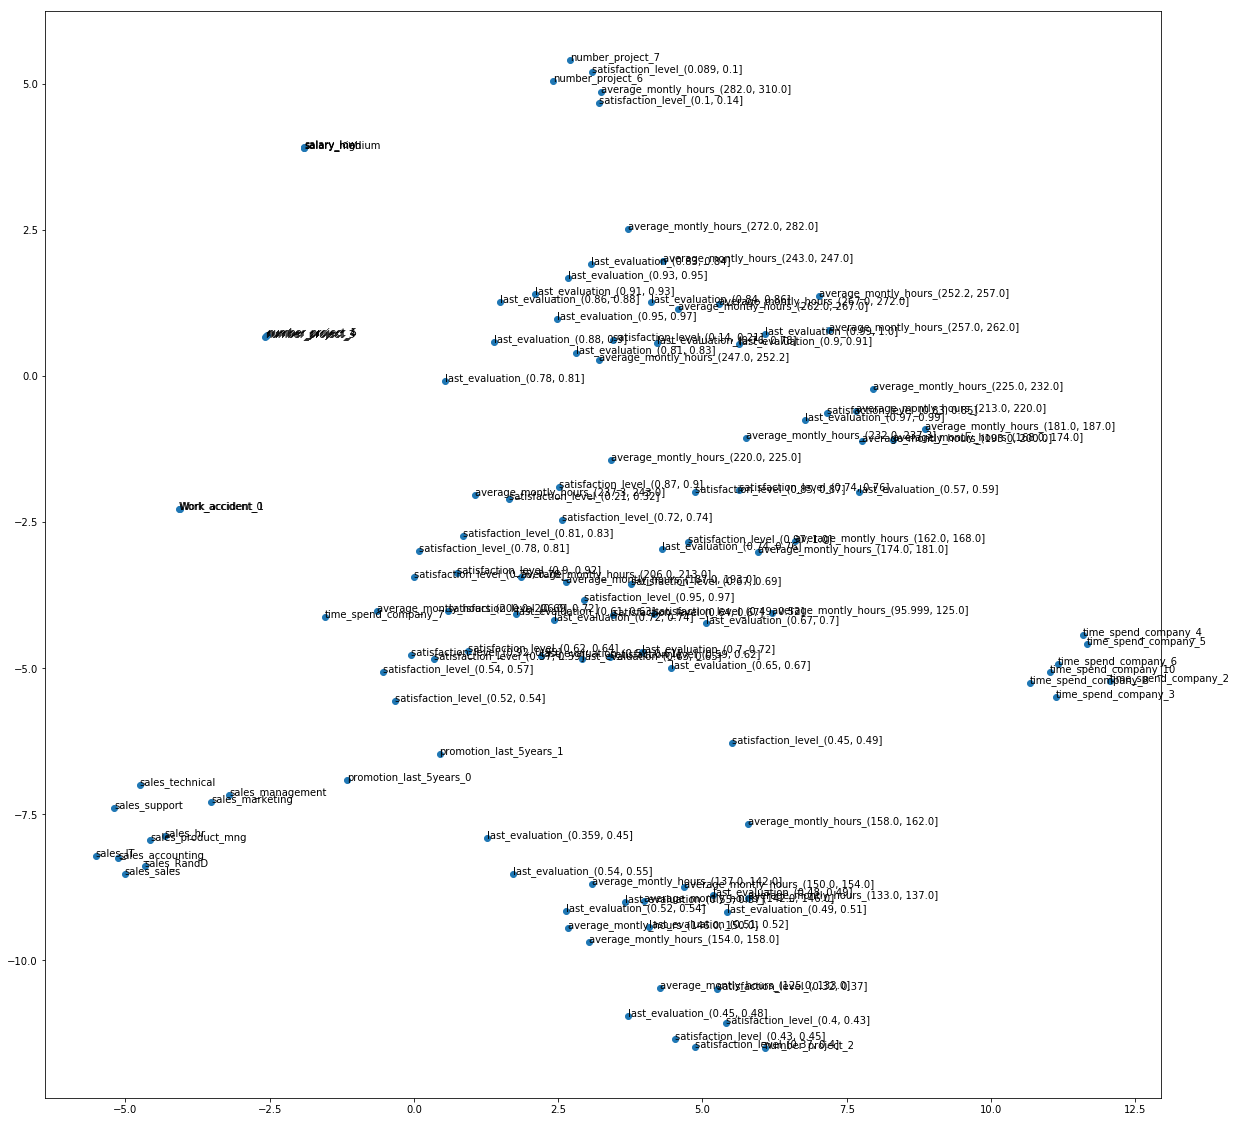

In [111]:
exp.semantic_binning.visualize_bin_embeddings()

In [71]:
for var in exp.var_dict['numerical_vars']:
    print(var)

satisfaction_level
last_evaluation
average_montly_hours


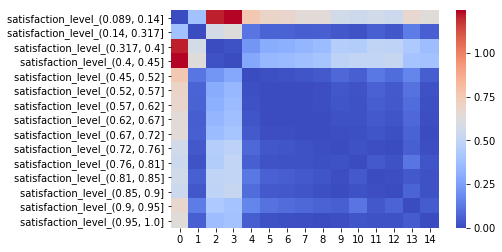

In [85]:
exp.semantic_binning.plot_pairwise_distance_between_bins('satisfaction_level')

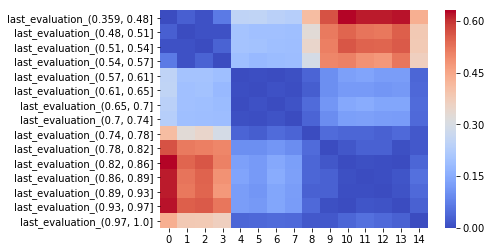

In [86]:
exp.semantic_binning.plot_pairwise_distance_between_bins('last_evaluation')

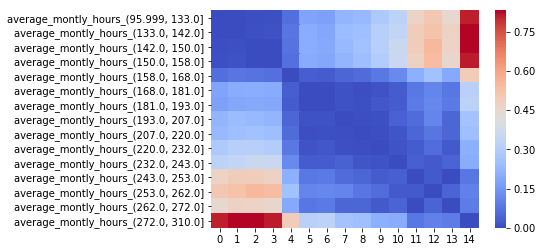

In [87]:
exp.semantic_binning.plot_pairwise_distance_between_bins('average_montly_hours')

In [67]:
for var, bins in exp.semantic_binning.bins_by_var.items():
    print(var)
    print(bins['bins'])

satisfaction_level
['(0.089, 0.14]', '(0.14, 0.31]', '(0.31, 0.45]', '(0.45, 1.0]']
last_evaluation
['(0.359, 0.57]', '(0.57, 1.0]']
average_montly_hours
['(95.999, 158.0]', '(158.0, 310.0]']


In [321]:
def find_nn(query, embedding_by_column, k=30, exclude_self=False):
    embedding_of_query = embedding_by_column[query]
    distances = dict()
    for col, embedding in embedding_by_column.items():
        distances[col] = np.linalg.norm(embedding - embedding_of_query)
    knn = sorted(distances.items(), key=lambda x: x[1])
    if exclude_self:
        knn = knn[1:]
    return knn[:k]

temp_cols = sorted([x for x in find_nn('average_montly_hours_(95.999, 133.0]', temp, k=100)
        if 'average_montly' in x[0]], key=lambda x: float(x[0].split('_')[-1].split(', ')[0][1:]))

### Convergence check

### Tracking #Cluster 

In [4]:
from data_handler import DataHandler

In [5]:
handler = DataHandler(exp.data, exp.var_dict)

In [6]:
from semantic_binning import SemanticBinning

In [7]:
sb = SemanticBinning(handler.var_dict, embedding_dim=8, batch_size=1024, 
                     n_epoch=100, lr=0.001, weight_decay=0.0,
                     inter_bin_distance_penalty=0.0, verbose=True)

In [ ]:
sb.fit(exp.data, n_init_bins=30)

>>> Epoch = 1, Loss = 0.6127415299415588
[24, 19, 20, 3, 6]
>>> Epoch = 2, Loss = 0.44309648871421814
[27, 16, 23, 3, 6]
>>> Epoch = 3, Loss = 0.31246325373649597
[27, 16, 21, 3, 6]
>>> Epoch = 4, Loss = 0.24994014203548431
[25, 13, 22, 3, 6]
>>> Epoch = 5, Loss = 0.2144279181957245
[27, 13, 19, 3, 6]
>>> Epoch = 6, Loss = 0.20129115879535675
[27, 13, 30, 3, 6]
>>> Epoch = 7, Loss = 0.1930326223373413
[28, 21, 27, 3, 6]
>>> Epoch = 8, Loss = 0.18779072165489197
[28, 23, 30, 3, 6]
>>> Epoch = 9, Loss = 0.18336395919322968
[27, 26, 28, 3, 6]
>>> Epoch = 10, Loss = 0.18241064250469208
[27, 25, 30, 3, 6]
>>> Epoch = 11, Loss = 0.1811157464981079
[28, 24, 29, 3, 6]
>>> Epoch = 12, Loss = 0.1800258755683899
[28, 25, 30, 3, 6]
>>> Epoch = 13, Loss = 0.17976108193397522
[26, 25, 26, 3, 4]
>>> Epoch = 14, Loss = 0.17859704792499542


In [ ]:
sb.bins_by_var['satisfaction_level']['bins']

In [ ]:
sb.plot_pairwise_distance_between_bins('satisfaction_level')

In [ ]:
sb.bins_by_var['last_evaluation']['bins']

In [ ]:
sb.plot_pairwise_distance_between_bins('last_evaluation')

In [ ]:
sb.bins_by_var['average_montly_hours']['bins']

In [ ]:
sb.plot_pairwise_distance_between_bins('average_montly_hours')

In [ ]:
sb.bins_by_var['number_project']['bins']

In [ ]:
sb.plot_pairwise_distance_between_bins('number_project')

In [ ]:
sb.bins_by_var['time_spend_company']['bins']

In [ ]:
sb.plot_pairwise_distance_between_bins('time_spend_company')

inter bin penalty가 없으면, bin 내부에서 cohesion이 제대로 잡히지 않아 클러스터 수가 적정 수준보다 적거나 많이 나옴

In [1]:
### 학습된 트리의 깊이, 형태 비교

In [ ]:
# dot_data = StringIO()
# export_graphviz(dt, out_file=dot_data, feature_names=X.columns, 
#                 impurity=False, proportion=True)
# graph = pydot.graph_from_dot_data(dot_data.getvalue())